In [1]:
from pysal.lib import weights
from pysal.explore import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn
import contextily

C:\Users\imdav\Anaconda3\envs\GeospatialPython\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# 1. Data Setup

In [155]:
# Reading in the data
path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

listings = pd.read_csv(path + r'NY Airbnb June 2020\listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough

path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'
boroughs = gpd.read_file(path + r"NYC Boroughs\nybb_22a\nybb.shp")
manhattan = boroughs[boroughs['BoroName']=='Manhattan']
manhattan = manhattan.to_crs('EPSG:4326')

listings_mask = listings_gpdf.within(manhattan.loc[3, 'geometry'])

listings_manhattan = listings_gpdf.loc[listings_mask]

In [ ]:
# Subsetting the data to a handful of variables that could be indicative of nightly airbnb price
voi = ['id' # Unique identifier for the listing
       ,'room_type' # Type of room
       ,'accommodates' # The maximum capacity of the listing 
       ,'bedrooms' # The number of bedrooms
       ,'beds' # The number of beds
       ,'review_scores_rating' # The rating
       ,'price' # The nightly rental rate, dependent variable (Y)
      ]

listings_manhattan_subset = listings_manhattan[voi]

## 1.1 Exploratory Data Analysis & Processing

In [ ]:
listings_manhattan_subset.dtypes

id                        int64
room_type                object
accommodates              int64
bedrooms                float64
beds                    float64
review_scores_rating    float64
price                    object
dtype: object

In [ ]:
for col in listings_manhattan[['room_type']]:
  print(listings_manhattan_subset[col].unique())

['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [ ]:
# Encoding categorical variables

# Room Type, All 0s = hotel room
listings_manhattan_subset['rt_entire_home_apartment'] = np.where(listings_manhattan_subset["room_type"]=='Entire home/apt', 1, 0)
listings_manhattan_subset['rt_private_room'] = np.where(listings_manhattan_subset["room_type"]=='Private room', 1, 0)
listings_manhattan_subset['rt_shared_room'] = np.where(listings_manhattan_subset["room_type"]=='Shared room', 1, 0)

In [ ]:
listings_manhattan_subset['price'].values

array(['$225.00', '$68.00', '$75.00', ..., '$93.00', '$462.00', '$113.00'],
      dtype=object)

In [ ]:
# Cleaning up the price column
listings_manhattan_subset['price'] = listings_manhattan_subset['price'].str.replace('$', '')
listings_manhattan_subset['price'] = listings_manhattan_subset['price'].str.replace(',', '')
listings_manhattan_subset['price'] = listings_manhattan_subset['price'].astype(float)

# Logging the price variable
listings_manhattan_subset['log_price'] = np.log(listings_manhattan_subset['price'])

In [ ]:
# Checking for missingness
print('Total Records:', len(listings_manhattan_subset))
listings_manhattan_subset.isna().sum()

Total Records: 15284


id                             0
room_type                      0
accommodates                   0
bedrooms                    2403
beds                         363
review_scores_rating        3738
price                          0
rt_entire_home_apartment       0
rt_private_room                0
rt_shared_room                 0
log_price                      0
dtype: int64

In [ ]:
listings_manhattan_subset = listings_manhattan_subset[listings_manhattan_subset['bedrooms'].notna()]
listings_manhattan_subset = listings_manhattan_subset[listings_manhattan_subset['review_scores_rating'].notna()]
listings_manhattan_subset = listings_manhattan_subset[listings_manhattan_subset['beds'].notna()]
listings_manhattan_subset.isna().sum()

id                          0
room_type                   0
accommodates                0
bedrooms                    0
beds                        0
review_scores_rating        0
price                       0
rt_entire_home_apartment    0
rt_private_room             0
rt_shared_room              0
log_price                   0
dtype: int64

# 2. OLS Regression Analysis

In [ ]:
from pysal.model import spreg

In [ ]:
# Defining a list of explanatory variables
m_vars = ['accommodates', 'bedrooms','beds','review_scores_rating',
          'rt_entire_home_apartment','rt_private_room','rt_shared_room'
         ]

In [ ]:
ols_m = spreg.OLS(
    listings_manhattan_subset[["log_price"]].values # the dependent variable (Y)
    ,listings_manhattan_subset[m_vars].values # the independent variables(Xs)
    ,name_y = 'price',
    name_x = m_vars
)

print(ols_m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       price                Number of Observations:        9471
Mean dependent var  :      5.1119                Number of Variables   :           8
S.D. dependent var  :      0.7428                Degrees of Freedom    :        9463
R-squared           :      0.4096
Adjusted R-squared  :      0.4092
Sum squared residual:    3084.716                F-statistic           :    937.8547
Sigma-square        :       0.326                Prob(F-statistic)     :           0
S.E. of regression  :       0.571                Log likelihood        :   -8126.601
Sigma-square ML     :       0.326                Akaike info criterion :   16269.203
S.E of regression ML:      0.5707                Schwarz criterion     :   16326.451

-----------------------------------------------------------------------------

## 2.1 Exploring unmodeled relationships

In [ ]:
# Creating a column to store the model residuals
listings_manhattan_subset["ols_m_r"] = ols_m.u

# Bringing back in the neighborhood variable
listings_manhattan_subset = listings_manhattan_subset.merge(listings_manhattan[['id','neighbourhood_cleansed']], how='left',on='id')

# Get average value of the residual by neighborhood
mean = (
    listings_manhattan_subset.groupby("neighbourhood_cleansed")
    .ols_m_r.mean()
    .to_frame("neighborhood_residual")
)

# Creating a dataframe to store the residuals by neighborhood
residuals_neighborhood = listings_manhattan_subset.merge(
        mean, how="left", left_on="neighbourhood_cleansed", right_index=True
    ).sort_values("neighborhood_residual")

In [ ]:
import plotly.express as px
import plotly.io as pio
from IPython.display import HTML

# Plotting the distribution of the residuals in a violin plot
fig = px.violin(residuals_neighborhood, x="neighbourhood_cleansed", y="ols_m_r", color="neighbourhood_cleansed", box=True)
# Updating the x and y axis labels
fig.update_layout(
    xaxis_title="Neighborhood", yaxis_title="Residuals"
)
HTML(fig.to_html())

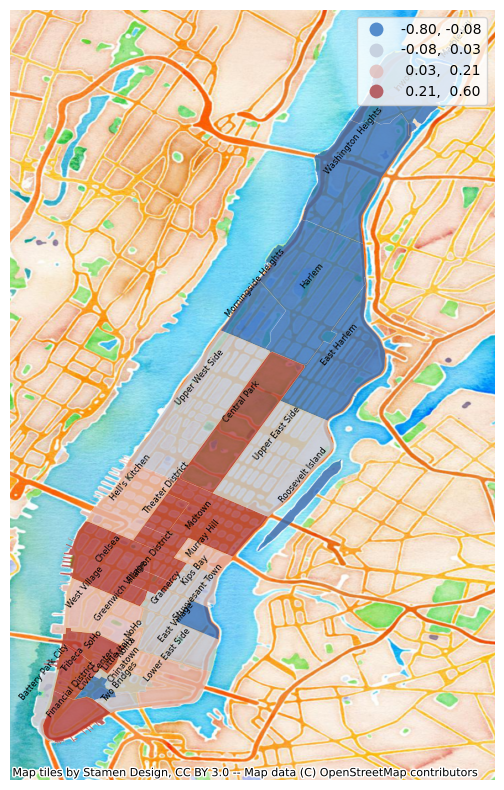

In [ ]:
# Producing a map of the average residual by neighborhood
import requests
import geopandas as gpd
from shapely.geometry import shape

# Reading in the NYC Neighborhoods shapefile from data file
import os
# Path
path = r"G:\My Drive\Geospatial Data Science with Python\Data"

nyc_n = gpd.read_file(os.path.join(path,r"NYC Neighborhoods\NYC_Neighborhoods.geojson"), driver='GeoJSON')

# Merging
nyc_n_r = nyc_n.merge(mean, left_on='neighborhood', right_on="neighbourhood_cleansed")

f, ax = plt.subplots(1, figsize=(10, 10))
   
# Plot choropleth of local statistics
nyc_n_r.plot(
    column='neighborhood_residual', 
    cmap='vlag', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

# Add basemap
contextily.add_basemap(
    ax,
    crs=nyc_n.crs,
    source=contextily.providers.Stamen.Watercolor,
)

for idx, row in nyc_n_r.iterrows():
    plt.annotate(text=row['neighborhood'], xy=tuple([row.geometry.centroid.x, row.geometry.centroid.y]),
                 horizontalalignment='center',fontsize=6, rotation=50)

# Remove axis
ax.set_axis_off()

# Display
plt.show()
#f.savefig(r"G:\My Drive\Geospatial Data Science with Python\Neighborhood Residuals.png")

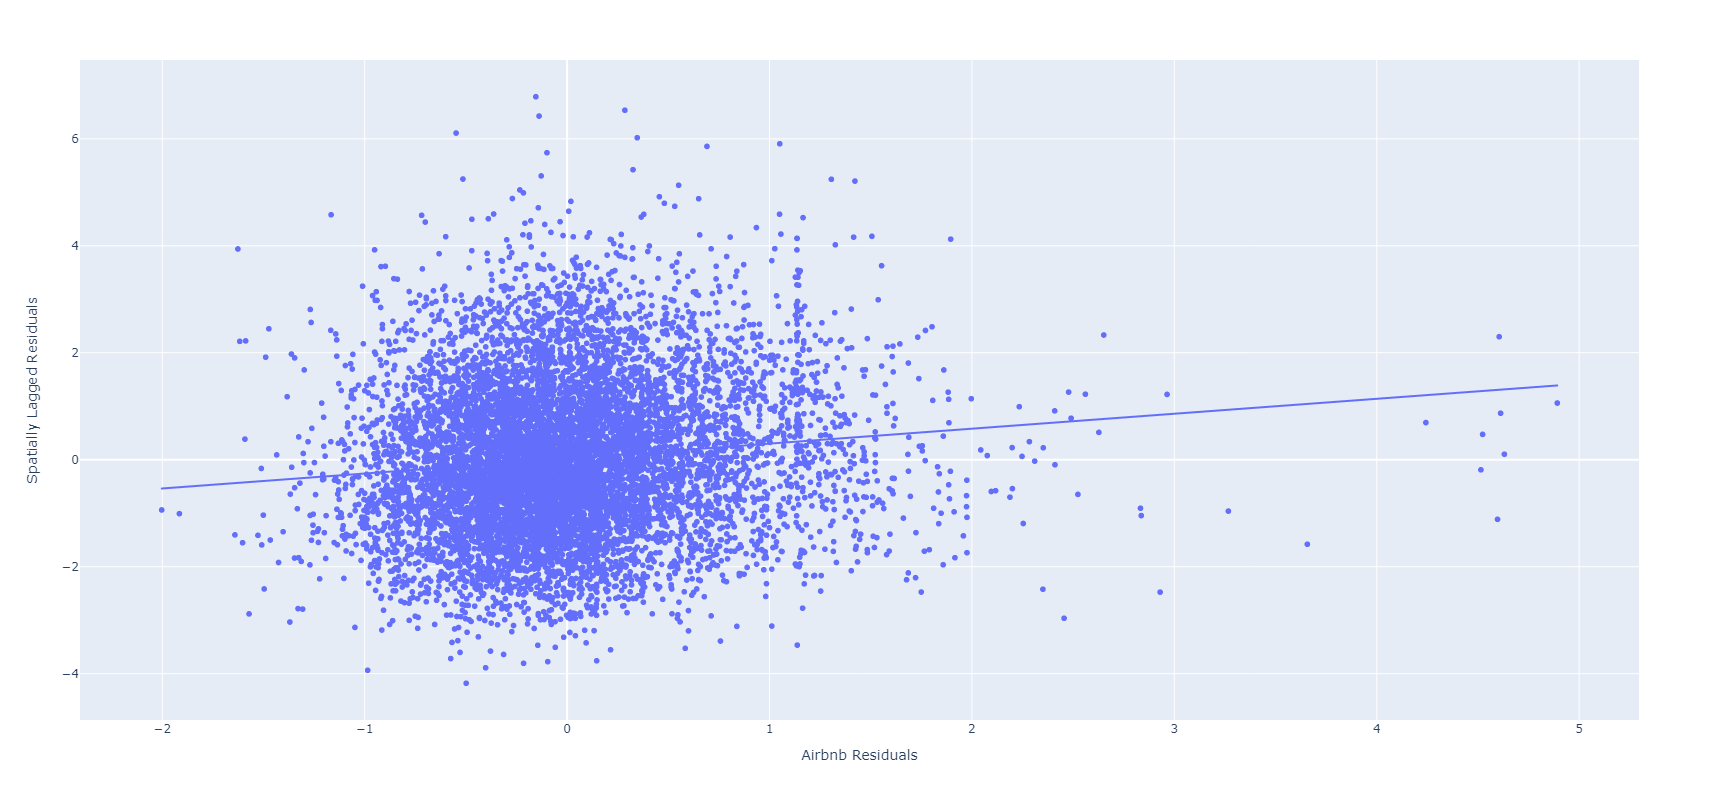

In [ ]:
# Bringing in the geometry attribute
residuals_neighborhood = residuals_neighborhood.merge(listings_manhattan[['id','geometry']], how='left',on='id')

# Building the spatial weights matrix
knn = weights.KNN.from_dataframe(residuals_neighborhood, k=5)

# Constructing the spatial lag
lag_residual = weights.spatial_lag.lag_spatial(knn, ols_m.u)

# Plotting the results
fig = px.scatter(x=ols_m.u.flatten(), y=lag_residual.flatten(), trendline="ols",
                width=800, height=800)

# Updating the x and y axis labels
fig.update_layout(
    xaxis_title="Airbnb Residuals", yaxis_title="Spatially Lagged Residuals"
)

fig.show()


# 3. OLS Regression Analysis w/ Spatial Atributes

## 3.1 Spatial Feature Engineering

In [ ]:
# Reading in data on popular NYC Attractions
path2 = r'G:\My Drive\Geospatial Data Science with Python\Data\NYC Attractions\\'
nyc_attr = pd.read_csv(path2 + 'NYC Attractions.csv')

# Convert PDF to GPDF
nyc_attr_gpdf =  gpd.GeoDataFrame(
    nyc_attr,
    geometry=gpd.points_from_xy(nyc_attr['Longitude'],
                                   nyc_attr['Latitude'],
                                   crs="EPSG:4326")
)

# Calculate the distance to each attraction per airbnb
attractions = nyc_attr_gpdf.Attraction.unique()

# Converting to a projected coordinate system
nyc_attr_gpdf_p = nyc_attr_gpdf.to_crs('EPSG:2263')
listings_manhattan_p = listings_manhattan.to_crs('EPSG:2263')

# Applying a lambda function that calls geopandas distance function to calcuate the distance between each airbnb and each attraction
distances = listings_manhattan_p.geometry.apply(lambda g: nyc_attr_gpdf_p.distance(g))

# Renaming the columns based on the attraction for which the distance is calculated
distances.columns = attractions

# Convert from 'US survey foot' to miles
distances = distances.apply(lambda x: x/5280, axis=1)

# Check to see which locations are less than 1 to 6 miles
distances_1mi = distances.apply(lambda x: x <=1, axis=1).sum(axis=1)
distances_2mi = distances.apply(lambda x: x <=2, axis=1).sum(axis=1)
distances_3mi = distances.apply(lambda x: x <=3, axis=1).sum(axis=1)
distances_4mi = distances.apply(lambda x: x <=4, axis=1).sum(axis=1)
distances_5mi = distances.apply(lambda x: x <=5, axis=1).sum(axis=1)
distances_6mi = distances.apply(lambda x: x <=6, axis=1).sum(axis=1)

# Creating a dataframe combining all the distance bands
distance_df = pd.concat([distances_1mi,distances_2mi,distances_3mi,distances_4mi,distances_5mi,distances_6mi], axis=1)
distance_df.columns = ['Attr_1mi','Attr_2mi','Attr_3mi','Attr_4mi','Attr_5mi','Attr_6mi']

# Joining back to the listings geopandas df
listings_manhattan = listings_manhattan.merge(distances, left_index=True, right_index=True)
listings_manhattan = listings_manhattan.merge(distance_df, left_index=True, right_index=True)

## 3.2 Modeling with Proximity Features

In [ ]:
# Geographic Features
g_vars = ['Central Park', 'Central Park Zoo', 'Empire State Building', 'Statue of Liberty', 
          'Rockeffeller Center', 'Chrysler Building', 'Times Square', 'MoMa', 'Charging Bull']

# Bring the geographic features into our subset
listings_manhattan_subset = listings_manhattan_subset.merge(listings_manhattan[['id','Central Park', 'Central Park Zoo', 'Empire State Building', 'Statue of Liberty', 
          'Rockeffeller Center', 'Chrysler Building', 'Times Square', 'MoMa', 'Charging Bull']], how='left',on='id')

# Adding geographic features to model variables used previously
g_m_vars = m_vars + g_vars

In [ ]:
ols_m_g = spreg.OLS(
    listings_manhattan_subset[["log_price"]].values,
    listings_manhattan_subset[g_m_vars].values,
    name_y = 'price',
    name_x = g_m_vars
)

print(ols_m_g.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       price                Number of Observations:        9471
Mean dependent var  :      5.1119                Number of Variables   :          17
S.D. dependent var  :      0.7428                Degrees of Freedom    :        9454
R-squared           :      0.5439
Adjusted R-squared  :      0.5431
Sum squared residual:    2383.177                F-statistic           :    704.5267
Sigma-square        :       0.252                Prob(F-statistic)     :           0
S.E. of regression  :       0.502                Log likelihood        :   -6904.724
Sigma-square ML     :       0.252                Akaike info criterion :   13843.449
S.E of regression ML:      0.5016                Schwarz criterion     :   13965.101

-----------------------------------------------------------------------------

In [ ]:
model_diagnostics = pd.DataFrame(
    [[ols_m.r2, ols_m.ar2], [ols_m_g.r2, ols_m_g.ar2]],
    index=["OLS_M", "OLS_M_G"],
    columns=["R2", "Adj. R2"],
)

model_diagnostics

R2   Adj. R2
OLS_M    0.409595  0.409158
OLS_M_G  0.543867  0.543095

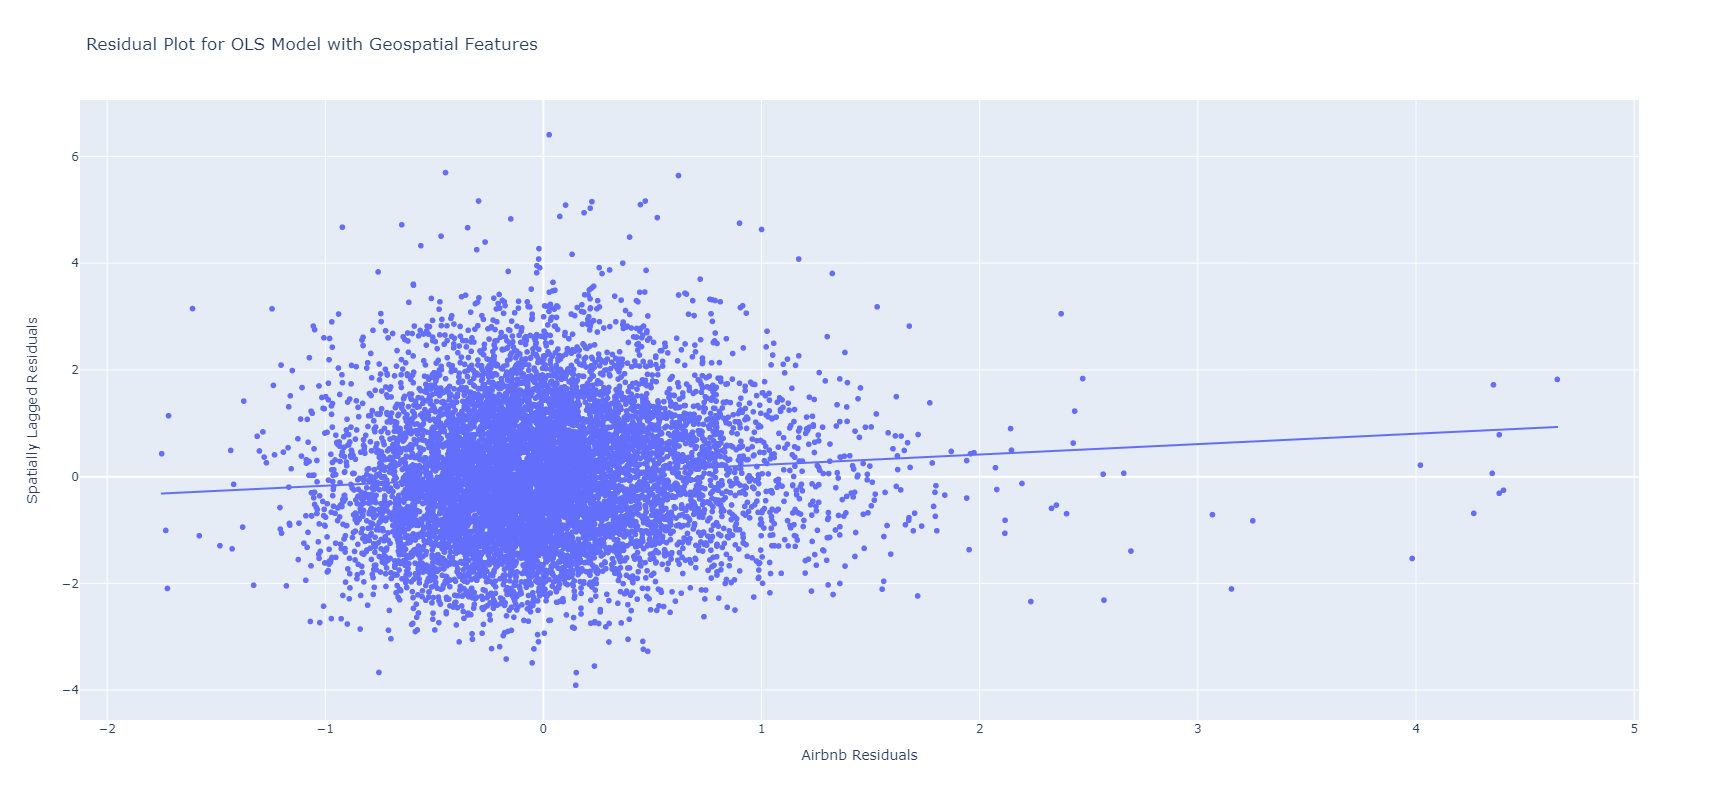

In [ ]:
# Constructing the spatial lag
lag_residual_2 = weights.spatial_lag.lag_spatial(knn, ols_m_g.u)

# Plotting the results
fig = px.scatter(x=ols_m_g.u.flatten(), y=lag_residual_2.flatten(), trendline="ols",
                width=800, height=800, title="Residual Plot for OLS Model with Geospatial Features")

# Updating the x and y axis labels
fig.update_layout(
    xaxis_title="Airbnb Residuals", yaxis_title="Spatially Lagged Residuals"
)

fig.show()

## 3.3 Spatial Fixed Effects Model

In [62]:
# Bringing back in the neighbourhood_cleansed variable
listings_manhattan_subset = listings_manhattan_subset.merge(listings_manhattan[['id','neighbourhood_cleansed']], how='left',on='id')

# spatial fixed effect model implementation
sfe_m = spreg.OLS_Regimes(
    #The dependent variable (Y) - Log Price (log_price)
    listings_manhattan_subset[["log_price"]].values,
    
    # The independent variables (Xs)
    listings_manhattan_subset[g_m_vars].values,
    
    # Variable which specifies which neighborhood each airbnb falls within
    listings_manhattan_subset["neighbourhood_cleansed"].tolist(),
    
    # Vary constant by each cross-section/group
    constant_regi="many",
    
    # Here we tell the model that the variables are kept constant by group
    cols2regi=[False] * len(g_m_vars),
    
    # Here we tell the model to estimate a single sigma coefficient
    regime_err_sep=False,
    
    # Dependent variable name
    name_y="log_price",
    
    # Independent variables names
    name_x=g_m_vars,
)
# printing the model summary
print(sfe_m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        9471
Mean dependent var  :      5.1119                Number of Variables   :          49
S.D. dependent var  :      0.7428                Degrees of Freedom    :        9422
R-squared           :      0.5632
Adjusted R-squared  :      0.5610
Sum squared residual:    2281.917                F-statistic           :    253.1438
Sigma-square        :       0.242                Prob(F-statistic)     :           0
S.E. of regression  :       0.492                Log likelihood        :   -6699.114
Sigma-square ML     :       0.241                Akaike info criterion :   13496.228
S.E of regression ML:      0.4909                Schwarz criterion     :   13846.872

---------------------------------------------------------

In [66]:
# Print Chow Statistic 
sfe_m.chow.joint

(418.10430113972586, 8.497470481401156e-69)